# Model 2 - using a CNN to predict accident location from satellite imagery

In this notebook, a convolutional neural network (CNN) is built using the satellite images that were scraped using Google's Static Maps API, in order to predict which areas are more likely to have traffic accidents. The images are labeled as safe or danger where safe images are those where there were no accidents and danger images were those with accidents.

In [226]:
# Importing libraries
import os, shutil
from keras import models, layers, optimizers, regularizers
import datetime
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import itertools
from sklearn.metrics import confusion_matrix, classification_report
np.random.seed(123)
import math
from keras.applications import VGG19
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd

## Moving downloaded images into the correct folder structure

In [145]:
data_danger_dir = 'model2_Images/danger/'
data_safe_dir = 'model2_Images/safe/'
new_dir = 'model2_split/'

In [ ]:
imgs_danger = [file for file in os.listdir(data_danger_dir) if file.endswith('.jpg')]

In [4]:
print('There are',len(imgs_danger), 'danger images')

There are 5000 danger images


In [5]:
imgs_safe = [file for file in os.listdir(data_safe_dir) if file.endswith('.jpg')]

In [6]:
print('There are',len(imgs_safe), 'safe images')

There are 5000 safe images


In [7]:
os.mkdir(new_dir)

In [3]:
train_folder = os.path.join(new_dir, 'train')
train_danger = os.path.join(train_folder, 'danger')
train_safe = os.path.join(train_folder, 'safe')

val_folder = os.path.join(new_dir, 'validation')
val_danger = os.path.join(val_folder, 'danger')
val_safe = os.path.join(val_folder, 'safe')

test_folder = os.path.join(new_dir, 'test')
test_danger = os.path.join(test_folder, 'danger')
test_safe = os.path.join(test_folder, 'safe')

In [9]:
train_danger

'model2_split/train\\danger'

In [10]:
os.mkdir(train_folder)
os.mkdir(train_danger)
os.mkdir(train_safe)

os.mkdir(val_folder)
os.mkdir(val_danger)
os.mkdir(val_safe)

os.mkdir(test_folder)
os.mkdir(test_danger)
os.mkdir(test_safe)

In [11]:
# train safe
imgs = imgs_safe[:3000]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(train_safe, img)
    shutil.copyfile(origin, destination)
    
# validation safe
imgs = imgs_safe[3000:4000]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(val_safe, img)
    shutil.copyfile(origin, destination)
    
# test safe
imgs = imgs_safe[4000:]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(test_safe, img)
    shutil.copyfile(origin, destination)

In [12]:
# train danger
imgs = imgs_danger[:3000]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(train_danger, img)
    shutil.copyfile(origin, destination)
    
# validation danger
imgs = imgs_danger[3000:4000]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(val_danger, img)
    shutil.copyfile(origin, destination)
    
# test danger
imgs = imgs_danger[4000:]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(test_danger, img)
    shutil.copyfile(origin, destination)

## Example images from each class

The images below are examples of 'danger' areas where there were accidents and 'safe' areas were there weren't any accidents. 

These examples show that dangerous areas include roads in suburban areas, larger roads and junctions (e.g. roundabouts, which are very common in the UK), but that not all images are necessarily only of roads - for example, the fourth image also contains a green area alongside the road where the accident/s occurred.

Safe areas include green areas with no roads (unsurprisingly), but also contain suburban areas with roads which have similarities with those where accidents did occur. These images will likely be more difficult for the CNN to classify, but are also important for it to learn from, as they will mean that the CNN is not just learning the differences between roads and fields but is also learning the differences between different types of road.

In [222]:
def show_image(image_path, size=[600, 400]):
    img = load_img(image_path, target_size=(size[0], size[1]))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.imshow(img_tensor[0])

In [223]:
imgs_danger_path = 'model2_split/test/danger'
imgs_danger = [file for file in os.listdir(imgs_danger_path) if file.endswith('.jpg')]

imgs_danger_plot = []
for img in imgs_danger[:5]:
    imgs_danger_plot.append(os.path.join(imgs_danger_path, img))
    
imgs_safe_path = 'model2_split/test/safe'
imgs_safe = [file for file in os.listdir(imgs_safe_path) if file.endswith('.jpg')]

imgs_safe_plot = []
for img in imgs_safe[:5]:
    imgs_safe_plot.append(os.path.join(imgs_safe_path, img))

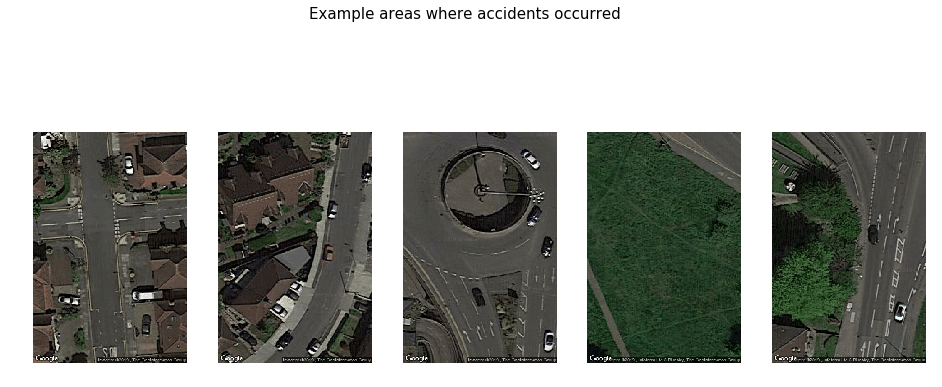

In [224]:
fig = plt.figure(figsize=(16,7))
for i, img in enumerate(imgs_danger_plot):
    fig.add_subplot(1,5,i+1)
    plt.suptitle('Example areas where accidents occurred', fontsize=15)
    show_image(img)
    plt.axis('off')

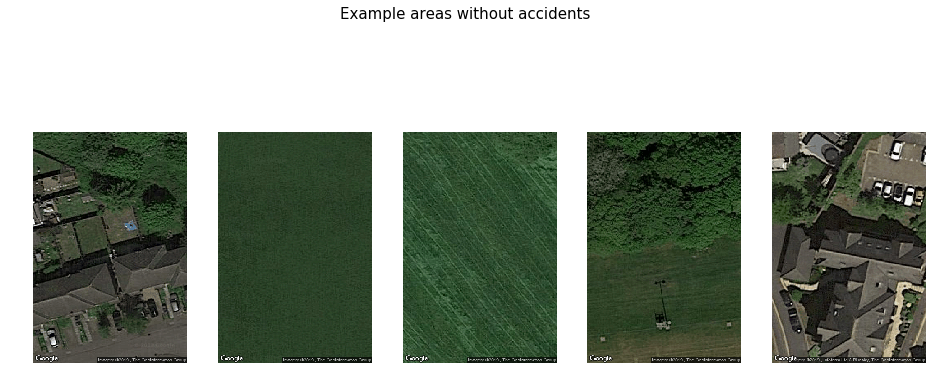

In [225]:
fig = plt.figure(figsize=(16,7))
for i, img in enumerate(imgs_safe_plot):
    fig.add_subplot(1,5,i+1)
    plt.suptitle('Example areas without accidents', fontsize=15)
    show_image(img)
    plt.axis('off')

## Model iteration 1: baseline CNN

For the first model iteration a simple CNN will be produced, with three convolutional layers followed by MaxPooling layers.

In [142]:
 # Get all the data in the directory model2_split/train (6000 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=6000, class_mode='binary')

 # Get all the data in the directory model2_split/val (2000 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size=2000, class_mode='binary')

# Get all the data in the directory model2_split/test (2000 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 2000, class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [143]:
# Check labels
train_generator.class_indices

{'danger': 0, 'safe': 1}

In [144]:
# Create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [145]:
# Checking the shapes of the datasets
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 6000
Number of validation samples: 2000
Number of testing samples: 2000
train_images shape: (6000, 64, 64, 3)
train_labels shape: (6000,)
val_images shape: (2000, 64, 64, 3)
val_labels shape: (2000,)
test_images shape: (2000, 64, 64, 3)
test_labels shape: (2000,)


In [147]:
# Construct baseline CNN

np.random.seed(123)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [148]:
# Training the model
history = model.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Train on 6000 samples, validate on 2000 samples
Epoch 1/10
6000/6000 [==============================] - 126s 21ms/step - loss: 0.6854 - acc: 0.5608 - val_loss: 0.6748 - val_acc: 0.6090
Epoch 2/10
6000/6000 [==============================] - 120s 20ms/step - loss: 0.6595 - acc: 0.6838 - val_loss: 0.6410 - val_acc: 0.7010
Epoch 3/10
6000/6000 [==============================] - 118s 20ms/step - loss: 0.6237 - acc: 0.6993 - val_loss: 0.6059 - val_acc: 0.6795
Epoch 4/10
6000/6000 [==============================] - 133s 22ms/step - loss: 0.5981 - acc: 0.6938 - val_loss: 0.6145 - val_acc: 0.6890
Epoch 5/10
6000/6000 [==============================] - 106s 18ms/step - loss: 0.5868 - acc: 0.6988 - val_loss: 0.5804 - val_acc: 0.7175
Epoch 6/10
6000/6000 [==============================] - 107s 18ms/step - loss: 0.5775 - acc: 0.7012 - val_loss: 0.5997 - val_acc: 0.6900
Epoch 7/10
6000/6000 [==============================] - 122s 20ms/step - loss: 0.5654 - acc: 0.7142 - val_loss: 0.6062 - val_acc: 

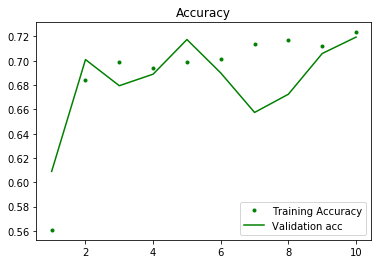

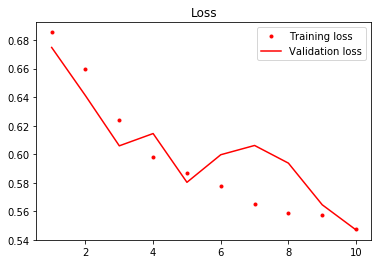

In [151]:
# Graph loss, accuracy for training and validation history
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

In [150]:
results_test = model.evaluate(test_images, test_labels)
print('Test Loss:', results_test[0])
print('Test Accuracy:', results_test[1])

2000/2000 [==============================] - 11s 6ms/step
Test Loss: 0.5429405093193054
Test Accuracy: 0.72


In [152]:
# Get predictions for confusion matrix
# Need to round predictions to whole numbers
predictions = model.predict(test_images)
predictions = np.round(predictions)

In [5]:
# Function for plotting easier to read confusion matrix
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

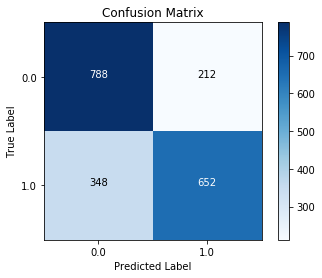

In [154]:
show_cf(test_labels, predictions)

In [155]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74      1000
         1.0       0.75      0.65      0.70      1000

   micro avg       0.72      0.72      0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



This initial model has performed reasonably well, with both train and test accuracy around 72% which is much better than random chance would be (50%). There also appears to be no overfitting. It also seems like loss and accuracy could possibly keep trending in their respective directions with more epochs.

For this project we would like our model to limit the number of False Positives (predicing 1=safe when the area is actually 0=danger). This is because these types of errors are much more costly compared to a model predicting dangerous areas when they are in fact safe. Therefore recall for the 'danger' (0) class is more important than precision. This initial CNN model has fewer False Positives than False Negatives, which is a good sign.

In [177]:
# Save model
model.save('models/cnn_v1.h5')

**Visualising the intermediate activations:**

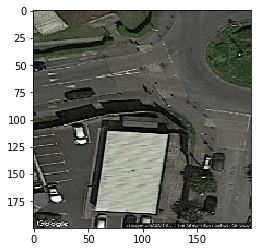

In [141]:
# Choosing an example image - this one has a building, two roads and a roundabout
show_image('model2_split/train/danger/51.4,-0.1335.jpg')

The images below show the activations for this image for each channel in each layer:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


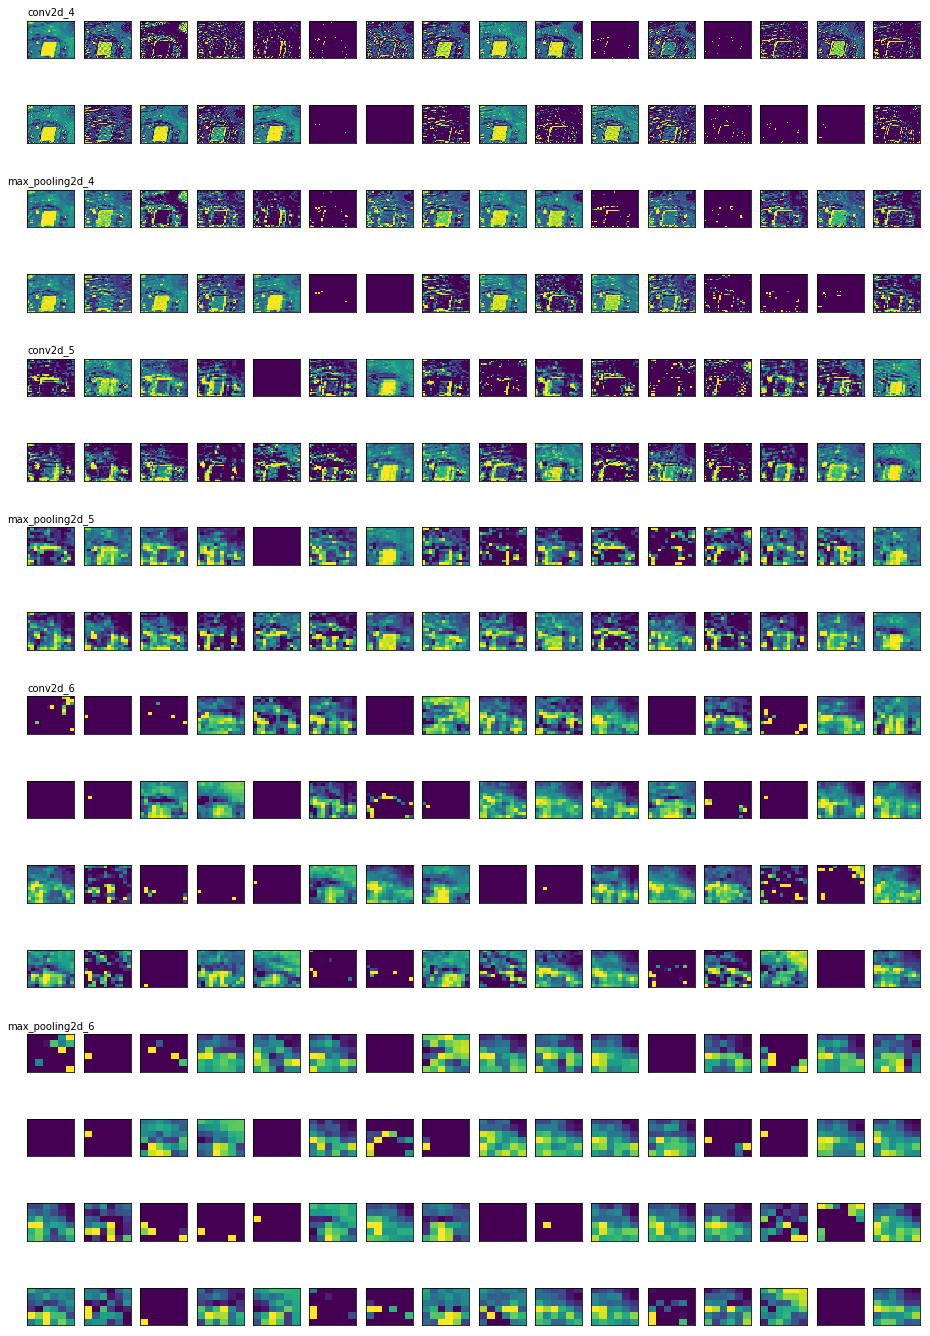

In [25]:
# Extract model layer outputs, excluding the final activation layers
layer_outputs = [layer.output for layer in model.layers[:6]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(danger_img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_columns = 16
n_rows = math.ceil(total_features / n_columns)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_columns
        column = iteration % n_columns
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig("Intermediate_Activations_Visualized.pdf")
plt.show()

## Model iteration 2: using a pre-trained model

We will now use feature extraction with a pre-trained CNN by taking the convolutional base of a pre-trained network, and running our satellite images through it. Then we will train a new classifier on top of the outputs. The pre-trained model chosen is VGG19.

In [158]:
# Use VGG19 for pre-trained model
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

In [159]:
# VGG19 summary
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [10]:
# Function for extracting features from VGG19 model
# Less expensive then training a CNN on top of frozen pre-trained model
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

def extract_features(directory, sample_amount, base_model, target_dimension=64, base_output_shape=(2,2,512)):
    features = np.zeros(shape=(sample_amount, base_output_shape[0], base_output_shape[1], base_output_shape[2])) # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(target_dimension, target_dimension), 
        batch_size = batch_size, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [163]:
# Extracting features
train_features_vgg, train_labels_vgg = extract_features(train_folder, 6000, cnn_base) 
val_features_vgg, val_labels_vgg = extract_features(val_folder, 2000, cnn_base)
test_features_vgg, test_labels_vgg = extract_features(test_folder, 2000, cnn_base)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [169]:
# Reshape the features to put into dense layer
train_features_vgg = np.reshape(train_features_vgg, (6000, 2 * 2 * 512))
val_features_vgg = np.reshape(val_features_vgg, (2000, 2 * 2 * 512))
test_features_vgg = np.reshape(test_features_vgg, (2000, 2 * 2 * 512))

In [171]:
# Use outputs from pretrained model and train on new densely connected classifier
model_vgg = models.Sequential()
model_vgg.add(layers.Dense(256, activation='relu', input_dim=2 * 2 * 512))
model_vgg.add(layers.Dense(1, activation='sigmoid'))

model_vgg.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history_vgg = model_vgg.fit(train_features_vgg, train_labels_vgg,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_features_vgg, val_labels_vgg))

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 7s 1ms/step - loss: 0.5699 - acc: 0.6993 - val_loss: 0.5430 - val_acc: 0.7055
Epoch 2/20
6000/6000 [==============================] - 6s 976us/step - loss: 0.5258 - acc: 0.7262 - val_loss: 0.5471 - val_acc: 0.7260
Epoch 3/20
6000/6000 [==============================] - 6s 995us/step - loss: 0.5118 - acc: 0.7365 - val_loss: 0.5269 - val_acc: 0.7155
Epoch 4/20
6000/6000 [==============================] - 6s 980us/step - loss: 0.5026 - acc: 0.7457 - val_loss: 0.5092 - val_acc: 0.7450
Epoch 5/20
6000/6000 [==============================] - 6s 994us/step - loss: 0.4966 - acc: 0.7433 - val_loss: 0.5094 - val_acc: 0.7435
Epoch 6/20
6000/6000 [==============================] - 6s 991us/step - loss: 0.4890 - acc: 0.7520 - val_loss: 0.5067 - val_acc: 0.7440
Epoch 7/20
6000/6000 [==============================] - 6s 1ms/step - loss: 0.4815 - acc: 0.7608 - val_loss: 0.5178 - val_acc: 0.7240
Epoc

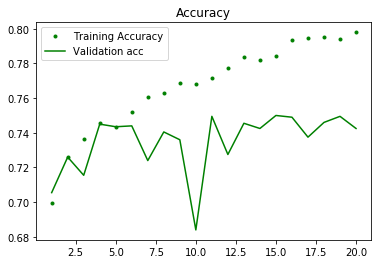

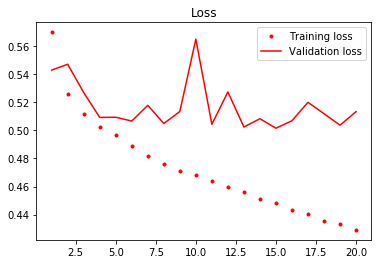

In [172]:
train_acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

In [173]:
results_test_vgg = model_vgg.evaluate(test_features_vgg, test_labels_vgg)
results_test_vgg

2000/2000 [==============================] - 1s 256us/step


[0.5167910249233246, 0.7445]

In [174]:
predictions_vgg = model_vgg.predict(test_features_vgg)
predictions_vgg = np.round(predictions_vgg)

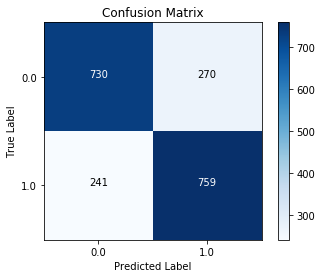

In [175]:
show_cf(test_labels_vgg, predictions_vgg)

In [176]:
print(classification_report(test_labels_vgg, predictions_vgg))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      1000
         1.0       0.74      0.76      0.75      1000

   micro avg       0.74      0.74      0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



The accuracy of this model is improved compared to the previous model (average F1 score of 0.74 compared to 0.72). However, there is now overfitting and an increase in False Positives, neither of which are desirable.

## Model iteration 3: VGG19 pre-trained model with larger inputs, regularization and more layers

In order to try and remove the overfitting seen in the previous model, L1 regularization will be used in the next model iteration. Additionally, to attempt to improve accuracy, larger inputs and more layers will be used.

In [8]:
# Get all the data in the directory model2_split/train (6000 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(200, 200), batch_size=6000, class_mode='binary')

 # Get all the data in the directory model2_split/val (2000 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(200, 200), batch_size=2000, class_mode='binary')

# Get all the data in the directory model2_split/test (2000 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(200, 200), batch_size = 2000, class_mode='binary')

# Create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

# Use VGG19 for pre-trained model
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
start = datetime.datetime.now()

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

# Extracting features
train_features_vgg2, train_labels_vgg2 = extract_features(train_folder, sample_amount=6000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))
val_features_vgg2, val_labels_vgg2 = extract_features(val_folder, sample_amount=2000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))
test_features_vgg2, test_labels_vgg2 = extract_features(test_folder, sample_amount=2000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Time taken to run: 2:04:47.403277


In [12]:
start = datetime.datetime.now()

# reshape the features to put into dense layer
train_features_vgg2 = np.reshape(train_features_vgg2, (6000, 6 * 6 * 512))
val_features_vgg2 = np.reshape(val_features_vgg2, (2000, 6 * 6 * 512))
test_features_vgg2 = np.reshape(test_features_vgg2, (2000, 6 * 6 * 512))

# Use outputs from pretrained model and train on new densely connected classifier
model_vgg2 = models.Sequential()
model_vgg2.add(layers.Dense(128, activation='relu', input_dim=6 * 6 * 512, kernel_regularizer=regularizers.l1(0.005)))
model_vgg2.add(layers.Dense(256, activation='relu', input_dim=6 * 6 * 512, kernel_regularizer=regularizers.l1(0.005)))
model_vgg2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.005)))

model_vgg2.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history_vgg2 = model_vgg2.fit(train_features_vgg2, train_labels_vgg2,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_features_vgg2, val_labels_vgg2))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 18s 3ms/step - loss: 40.9591 - acc: 0.6913 - val_loss: 9.6287 - val_acc: 0.6820
Epoch 2/20
6000/6000 [==============================] - 12s 2ms/step - loss: 8.0752 - acc: 0.6973 - val_loss: 6.8187 - val_acc: 0.6800
Epoch 3/20
6000/6000 [==============================] - 13s 2ms/step - loss: 5.7972 - acc: 0.7042 - val_loss: 4.8839 - val_acc: 0.6765
Epoch 4/20
6000/6000 [==============================] - 12s 2ms/step - loss: 4.0743 - acc: 0.7063 - val_loss: 3.4147 - val_acc: 0.6760
Epoch 5/20
6000/6000 [==============================] - 13s 2ms/step - loss: 2.7983 - acc: 0.7152 - val_loss: 2.3263 - val_acc: 0.6840
Epoch 6/20
6000/6000 [==============================] - 12s 2ms/step - loss: 1.9664 - acc: 0.7127 - val_loss: 1.7189 - val_acc: 0.674563 - acc:
Epoch 7/20
6000/6000 [==============================] - 12s 2ms/step - loss: 1.5614 - acc: 0.7215 - val_loss: 1.5127 - val_acc: 0.68

In [13]:
model_vgg2.save('models/cnn_v3.h5')

In [4]:
def cnn_evaluation(model, history, train_features, train_labels, test_features, test_labels, class_names=None, model_name=None):
    """
    Evaluates the performance of a CNN with loss and accuracy plots, a confusion matrix and a classification report for the training and test sets.
    """
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    results_test = model.evaluate(test_features, test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    y_train_pred = np.round(model.predict(train_features))
    y_pred = np.round(model.predict(test_features))
    
    show_cf(test_labels, y_pred, class_names=class_names, model_name=model_name)
    
    print(classification_report(train_labels, y_train_pred))
    print(classification_report(test_labels, y_pred))

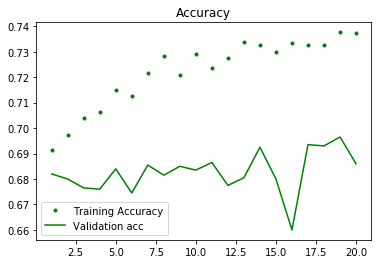

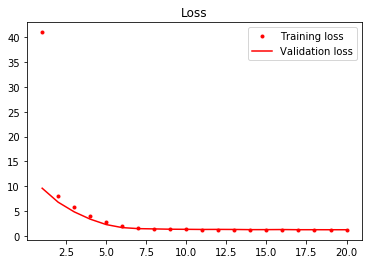

2000/2000 [==============================] - 3s 1ms/step
Test Loss: 1.224921414375305
Test Accuracy: 0.771
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72      3000
         1.0       0.71      0.75      0.73      3000

   micro avg       0.73      0.73      0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000

              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76      1000
         1.0       0.74      0.83      0.78      1000

   micro avg       0.77      0.77      0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



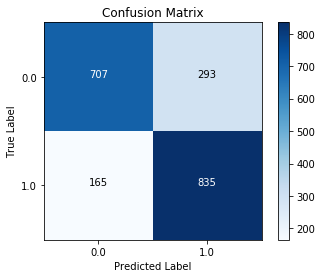

In [17]:
cnn_evaluation(model_vgg2, history_vgg2, train_features_vgg2, train_labels_vgg2, test_features_vgg2, test_labels_vgg2)

This model performs better than model iteration 2 (average F1 score of 0.77 vs 0.74). It has slightly more overfitting and slightly more False Positives than model iteration 1, which could potentially be improved upon. However, overall this is the preferred model due to its better accuracy score.

## Summary and potential directions for future work

The best model produced was version 3, using a VGG19 pre-trained model. It achieved an average F1 score of 0.77.

To try and improve the accuracy of the model and reduce overfitting, some of the following could be tried in further model iterations:
- Download more images for use in training
- Use a different pre-trained model, e.g. ResNet50, which has been used in other CNNs for satellite imagery (e.g. [here](https://www.researchgate.net/publication/331557018_Convolutional_Neural_Network_for_Satellite_Image_Classification) and [here](https://medium.com/data-from-the-trenches/object-detection-with-deep-learning-on-aerial-imagery-2465078db8a9))
- Freeze specific layers of the pre-trained model and fine-tune other layers
- Change the architecture of the densely connected classifier on top of the pre-trained model (e.g. adding more layers or nodes)